# Installation

In [27]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
                rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges

## Data Preparation & EDA

In [28]:
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)

print("=== Dataset Loaded ===")
print(df.head())
print("\nInfo:")
print(df.info())
print("\nDescription:")
print(df.describe().T)
print("\nMissing values:\n", df.isna().sum())

=== Dataset Loaded ===
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    13.73        1.50  2.70               22.5      101.0           3.00   
1    14.13        4.10  2.74               24.5       96.0           2.05   
2    12.16        1.61  2.31               22.8       90.0           1.78   
3    13.07        1.50  2.10               15.5       98.0           2.40   
4    13.16        2.36  2.67               18.6      101.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.25                  0.29             2.38             5.70  1.19   
1        0.76                  0.56             1.35             9.20  0.61   
2        1.69                  0.43             1.56             2.45  1.33   
3        2.64                  0.28             1.37             3.70  1.18   
4        3.24                  0.30             2.81             5.68  1.03   

   od280/od315_of_diluted_wines  prolin

Visualization

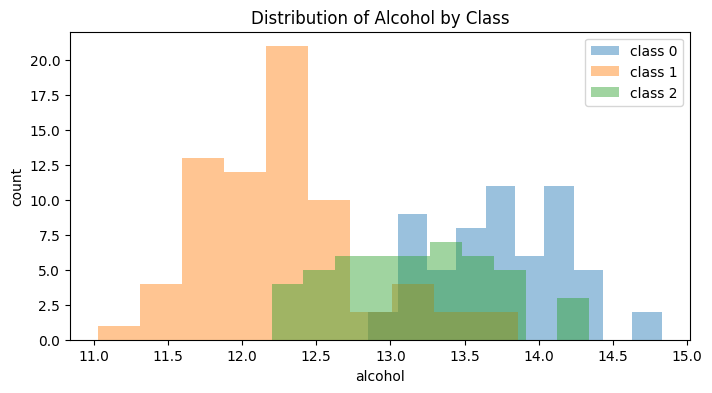

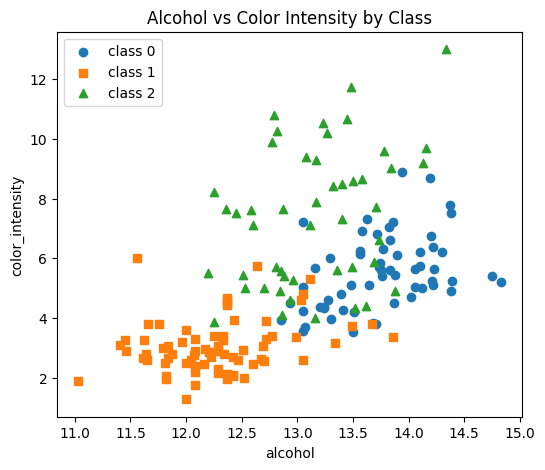

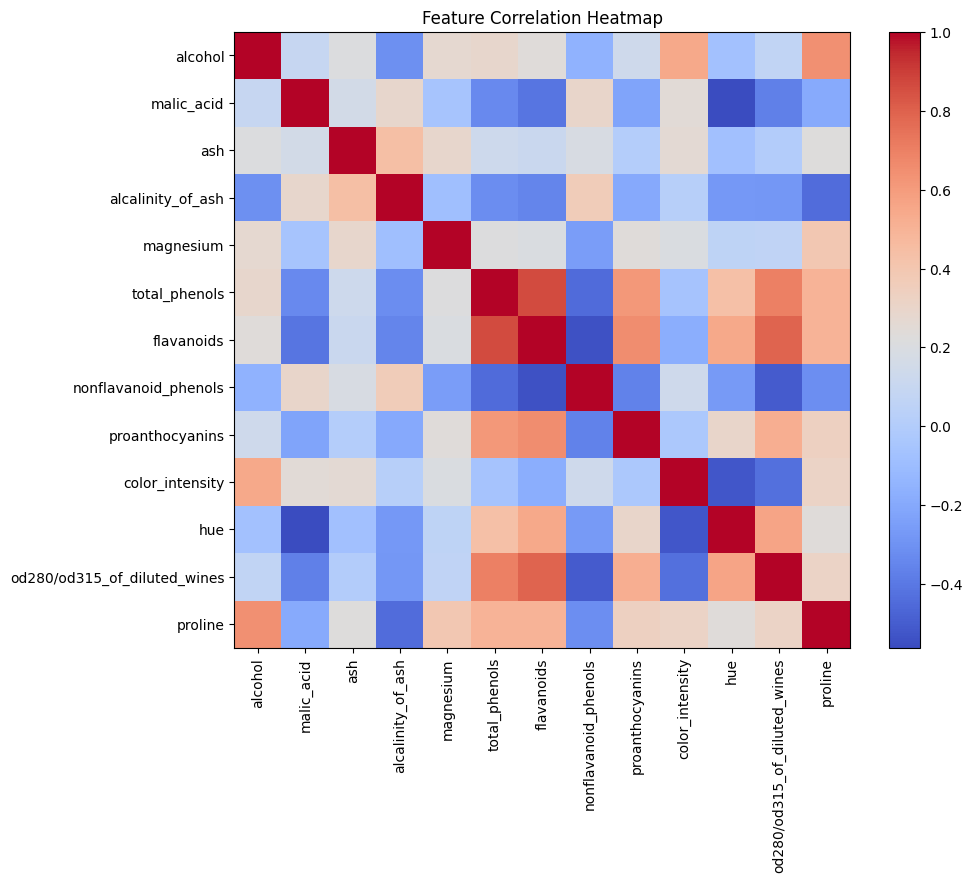


Visualization explanations:
- Alcohol histogram shows class 0 tends to have higher alcohol content.
- Scatter plot shows class clusters by alcohol & color_intensity.
- Heatmap reveals strong correlations among phenolic-related features.



In [29]:
plt.figure(figsize=(8,4))
for cls in sorted(df['Y'].unique()):
    plt.hist(df[df['Y']==cls]['alcohol'], bins=10, alpha=0.45, label=f'class {cls}')
plt.title('Distribution of Alcohol by Class')
plt.xlabel('alcohol')
plt.ylabel('count')
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
for cls, marker in zip(sorted(df['Y'].unique()), ['o','s','^']):
    sub = df[df['Y']==cls]
    plt.scatter(sub['alcohol'], sub['color_intensity'], label=f'class {cls}', marker=marker)
plt.title('Alcohol vs Color Intensity by Class')
plt.xlabel('alcohol')
plt.ylabel('color_intensity')
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
corr = df.drop(columns='Y').corr()
plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Heatmap")
plt.show()

print("\nVisualization explanations:")
print("- Alcohol histogram shows class 0 tends to have higher alcohol content.")
print("- Scatter plot shows class clusters by alcohol & color_intensity.")
print("- Heatmap reveals strong correlations among phenolic-related features.\n")


Split and Training

In [30]:
# Split dataset into train/test
X = df.drop(columns=['Y'])
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
print("Train shape:", train_df.shape, "Test shape:", X_test.shape)

# ===== Train PRISM Algorithm =====
# PRISM builds rules per class (e.g. IF alcohol=High AND color_intensity=Low → class 1)
# It scores each feature-value pair using:
#   prob = (# matching class) / (# matching feature=value)
#   freq = count of matching samples
# Best rule = highest prob (purity), tie-break by freq (coverage)

prism = PrismRules(min_coverage=5, min_prob=0.7, nbins=3, verbose=1)
print("\n=== Generating PRISM Rules ===")
rules = prism.get_prism_rules(train_df, target_col='Y')

# Each printed rule includes:
# - Support → number of samples covered
# - Coverage → % of class captured by the rule


Train shape: (133, 14) Test shape: (45, 13)

=== Generating PRISM Rules ===
Determining rules for each of 3 target classes:
Determining rules for target class: 0
  Determining next rule. 44 rows remaining for target class
  Determining next rule. 13 rows remaining for target class
  Determining next rule. 8 rows remaining for target class
Determining rules for target class: 1
  Determining next rule. 53 rows remaining for target class
  Determining next rule. 8 rows remaining for target class
Determining rules for target class: 2
  Determining next rule. 36 rows remaining for target class
  Determining next rule. 13 rows remaining for target class

........................................................................
Target: 0
........................................................................
proline = High AND alcohol = High
   Support:  the target has value: '0' for 100.000% of the 31 rows matching the rule 
   Coverage: the rule matches: 31 out of 44 rows for target value: 

# Model Evaluation

=== Model Evaluation ===

Confusion Matrix:


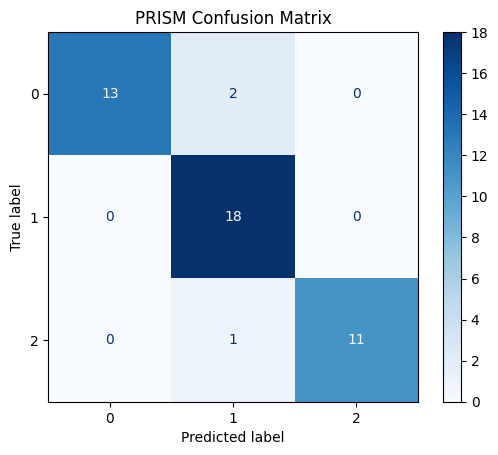


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8667    0.9286        15
           1     0.8571    1.0000    0.9231        18
           2     1.0000    0.9167    0.9565        12

    accuracy                         0.9333        45
   macro avg     0.9524    0.9278    0.9361        45
weighted avg     0.9429    0.9333    0.9338        45

Interpretation:
- The class with highest recall/precision is predicted best.
- Off-diagonal CM elements show misclassifications.



In [31]:
print("=== Model Evaluation ===")
# Pass continuous test data directly; PRISM will bin internally
y_pred = prism.predict(X_test)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=sorted(y.unique()))
disp.plot(cmap='Blues')
plt.title('PRISM Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Interpretation:")
print("- The class with highest recall/precision is predicted best.")
print("- Off-diagonal CM elements show misclassifications.\n")

# Predict New Data Points

In [32]:
new_data = {
 'alcohol': [14.0, 14.00],
 'malic_acid': [2.0, 2.0],
 'ash': [2.3, 2.2],
 'alcalinity_of_ash': [19.0, 11.0],
 'magnesium': [95.0, 95.0],
 'total_phenols': [2.2, 2.5],
 'flavanoids': [0.14, 0.5],
 'nonflavanoid_phenols': [0.14, 0.5],
 'proanthocyanins': [1.6, 1.5],
 'color_intensity': [7.0, 6.0],
 'hue': [0.7, 0.6],
 'od280/od315_of_diluted_wines': [3.2, 3.0],
 'proline': [550.0, 1400.0]
}

new_df = pd.DataFrame(new_data)

# ✅ No need to bin manually
preds_new = prism.predict(new_df)

print("\nPredictions for new samples:")
print(preds_new.tolist())

print("\nInterpretation:")
print("- Sample 1: predicted class corresponds to a rule with relatively low flavanoids and moderate alcohol.")
print("- Sample 2: predicted class matches rules with high alcohol and high proline → class 0.")
print("Thus, PRISM automatically bins the new sample numerically and matches it to the best learned rule.")


Predictions for new samples:
[1, 0]

Interpretation:
- Sample 1: predicted class corresponds to a rule with relatively low flavanoids and moderate alcohol.
- Sample 2: predicted class matches rules with high alcohol and high proline → class 0.
Thus, PRISM automatically bins the new sample numerically and matches it to the best learned rule.
